In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from skimage import exposure

# Read dm4 images from a specified folder
The following function reads all the dm4 files in a given folder and returns a list of images:

In [2]:
from ncempy.io import dm

def load_images_from_folder(pathName):
    '''
    Read dm4 images from a specified path using the ncempy package in python
    Returns the a list of images
    
    '''

    images = []
    scales = []
    for filename in os.listdir(pathName):  # Goes through every file in the given pathName
        if os.path.isfile(os.path.join(pathName, filename)): # Separate files from folders
            if (filename.split('.')[1] == 'dm4'): # Check if the extension is .dm4
                with dm.fileDM(filename) as dmFile1: # Read the dm4 file
                    dataSet = dmFile1.getDataset(0)
                    image = dataSet['data']
                    scale = dmFile1.scale
                if image is not None:
                    images.append(image)  # Save all the iamges in a list
                    scales.append(scale)
    return images, scales
 

In [3]:
# Specify the path where dm4 files are stored in
folder = 'C:\\Users\\Hsafari\\Desktop\\SEM\\BB'

images, scales = load_images_from_folder(folder)

In [4]:
scales_img = np.zeros(len(images))
for i in range(len(images)):
    scales_img[i] = scales[i][3]
    
scale_img = scales_img.reshape(len(images),1)

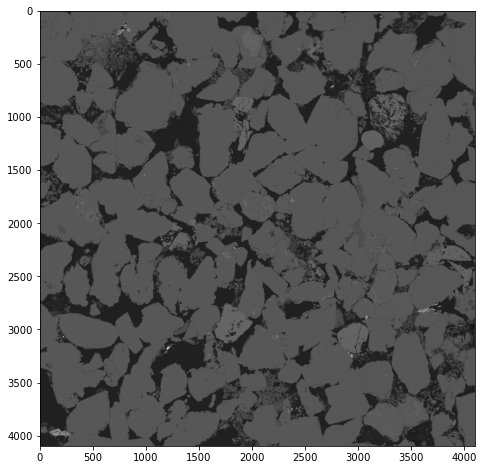

In [5]:
# Visualize a single image from the list
plt.figure(figsize=(8,8))
plt.imshow(images[0], cmap='gray')

After ncempy reads dm4 files, the intensity requires some enhancements. This correction is applied by rescaling the image and adjsuting its histogram. I prefer rescaling to histogram equalization because it doesn't change the image type from 16-bit to float.

In [6]:
img_rescale_final = []
img_eq_final = []

for i in tqdm(range(len(images))):
    # Contrast stretching
    p2, p98 = np.percentile(images[i], (2, 98))
    img_rescale = exposure.rescale_intensity(images[i], in_range=(p2, p98)) #equivalent to stretchlimit function in MATLAB 
    img_rescale_final.append(img_rescale)
    # Equalization
    # img_eq = exposure.equalize_hist(images[i])
    # img_eq_final.append(img_eq)

100%|██████████| 12/12 [00:09<00:00,  1.24it/s]


In [7]:
type(img_rescale_final[1][1][1])

numpy.uint16

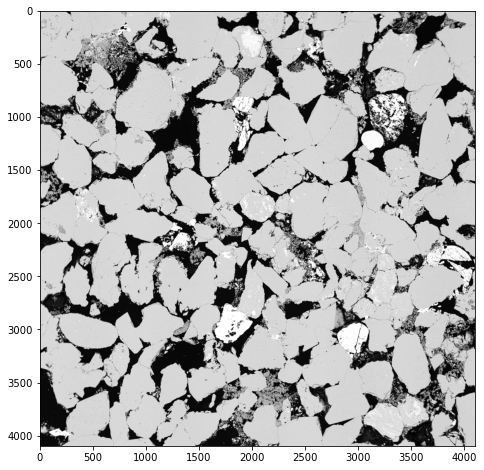

In [8]:
# Visualize a single image from the list and see how much the image has been enhanced
plt.figure(figsize = (8,8))
plt.imshow(img_rescale_final[0],cmap='gray')


Text(0, 0.5, 'frequency')

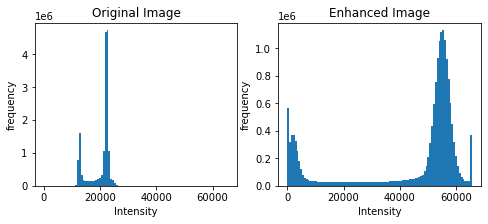

In [9]:
plt.figure(num=None, figsize=(8, 3))
plt.subplot(121)
plt.hist(images[0].flat, bins =100, range=(0,65536));
plt.title('Original Image')
plt.xlabel('Intensity')
plt.ylabel('frequency')

plt.subplot(122)
plt.hist(img_rescale_final[0].flat, bins =100, range=(0,65536));
plt.title('Enhanced Image')
plt.xlabel('Intensity')
plt.ylabel('frequency')

Next step is to convert the list of image arrays into list of PIL images so we could save high quality images into a folder

In [10]:
from PIL import Image

def convert_to_PIL(images):

    image_list = []
    for i in tqdm(range(len(images))):
        image = Image.fromarray(images[i])
        image_list.append(image)
        
    return image_list


In [11]:
# Convert list of image arrays into list of PIL images
#image_list = convert_to_PIL(img_rescale_final)
#len(image_list)

# Save images into a subfolder
The following function takes a list of PIL images, the main path, subfolder, and extension for the images to be saved . The default extension is .tif

In [12]:
import os
from tqdm import tqdm

def save_images(image_list, folder, subfolder, ext = '.tif'):
    '''
    Save dm4 images read by ncemtpy package from a list into a folder with a given extension
    image_list -> a list of PIL images
    folder -> main path where all the files are
    subfolder -> name of the subfolder
    ext -> image extension which by default is .tif
    '''
    
    os.makedirs(subfolder, exist_ok=True) 
    
    save_img_path = []
    for filename in os.listdir(folder):
        if os.path.isfile(os.path.join(folder, filename)):
            if (filename.split('.')[1] == 'dm4'):
                save_img_path.append(folder + '\\' + subfolder + '\\' + filename.split('.')[0] + ext)
                
    for i in tqdm(range(len(image_list))):
        image_list[i].save(save_img_path[i]) # image_list is a list of PIL images
        
    return None

In [13]:
# Save all the PIL images into a subfolder
#save_images(image_list, folder, 'Tiff Images', ext = '.tif')

# MUlti-Otsu Thresholding
After reading all the SEM images, the Otsu's multi-thresholding approach could be used to segment the images into several phases

In [8]:
from skimage.filters import threshold_multiotsu
from skimage import img_as_float, img_as_uint, img_as_ubyte

def MultiThreshold_Segmentation(images, segments):
    '''
    Performs a multi-otsu segmentation on the given list of images
    '''
    
    Seg_list = []
    Threshs = []
    for i in tqdm(range(len(images))):
        # Apply multi-Otsu threshold 
        thresholds = threshold_multiotsu(img_as_ubyte(images[i]), classes=segments)
        # Digitize (segment) original image into multiple classes.
        #np.digitize assign values 0, 1, 2, 3, ... to pixels in each class.
        regions = np.digitize(img_as_ubyte(images[i]), bins=thresholds)
        output = regions  # Convert an image to unsigned integer format, with values in [0, 65535]
        Seg_list.append(output)
        Threshs.append(thresholds)
        
    return Seg_list, Threshs


In [9]:
Segmented_img, Thresholds = MultiThreshold_Segmentation(img_rescale_final, 4)

100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


In [16]:
Thresholds

[array([ 65, 158, 213]),
 array([ 67, 158, 220]),
 array([ 66, 158, 218]),
 array([ 67, 158, 211]),
 array([ 65, 158, 217]),
 array([ 67, 159, 220]),
 array([ 64, 157, 212]),
 array([ 69, 161, 213]),
 array([ 65, 156, 210]),
 array([ 66, 157, 210]),
 array([ 64, 154, 218]),
 array([ 65, 157, 211])]

(-0.5, 4095.5, 4095.5, -0.5)

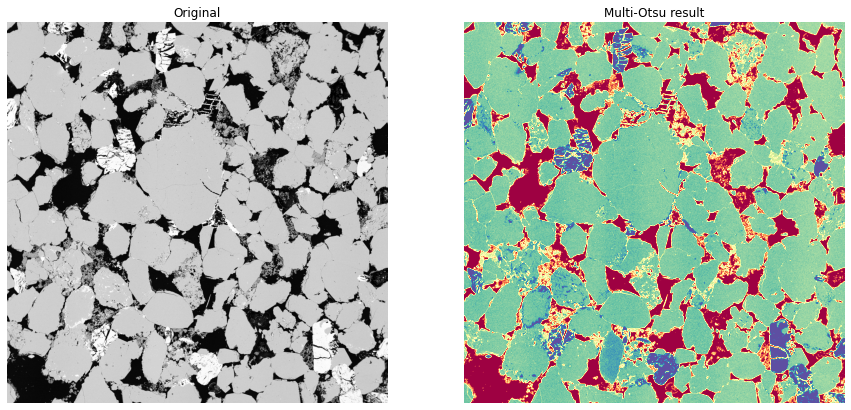

In [17]:
image = Segmented_img[11]
# Plotting the Multi Otsu result.
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img_rescale_final[11], cmap='gray')
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(image, cmap='Spectral')
plt.title('Multi-Otsu result')
plt.axis('off')

In [18]:
def multiotsu_plot(image,regions,thresholds):
    ''' 
    Plot the image, its histogram, and the thresholded image
    
    '''
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

    # Plotting the original image.
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')

    # Plotting the histogram and the two thresholds obtained from
    # multi-Otsu.
    ax[1].hist(image.ravel(), bins=255)
    ax[1].set_title('Histogram')
    for thresh in thresholds:
        ax[1].axvline(thresh, color='r')

    # Plotting the Multi Otsu result.
    ax[2].imshow(regions, cmap='Spectral')
    ax[2].set_title('Multi-Otsu result')
    ax[2].axis('off')

    plt.subplots_adjust()
    fig.tight_layout()

    plt.show()
    return None

When I first applied multi-otsu segmentation, the coloring of labels was different from one image to the other. My first hunch was that it assigned labels differently for every image. So I plotted a few images and checked the assigned labels for image intensity levels. Fortunately, the labels were assigned in proper sequences based on intnsity thresholds in the images. However, the colormaps assigned to each image seems to have a randomness to it which I wasn't able to figure how to fix after an exhaustive search on the internet. Actually, I think colormaps are assigned based on which label appears first in the image origin (0,0).

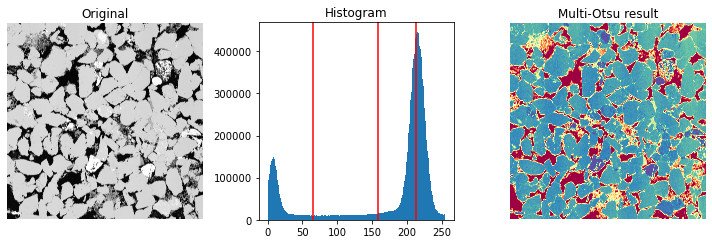

In [19]:
from skimage import img_as_ubyte
image0 =img_as_ubyte(img_rescale_final[0])
regions0 = Segmented_img[0]
thresholds0 = Thresholds[0]
multiotsu_plot(image0,regions0,thresholds0)

In [20]:
image0

array([[207, 203, 206, ..., 223, 200, 207],
       [214, 215, 194, ..., 212, 214, 203],
       [222, 208, 228, ..., 225, 210, 217],
       ...,
       [  7,  15,  16, ..., 203, 217, 202],
       [ 12,  13,  14, ..., 212, 216, 206],
       [  5,  13,   7, ..., 193, 197, 225]], dtype=uint8)

In [21]:
regions0

array([[2, 2, 2, ..., 3, 2, 2],
       [3, 3, 2, ..., 2, 3, 2],
       [3, 2, 3, ..., 3, 2, 3],
       ...,
       [0, 0, 0, ..., 2, 3, 2],
       [0, 0, 0, ..., 2, 3, 2],
       [0, 0, 0, ..., 2, 2, 3]], dtype=int64)

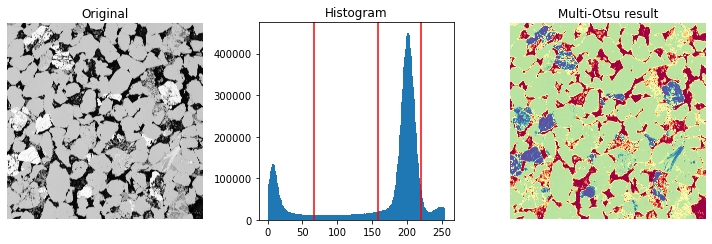

In [22]:
image1 =img_as_ubyte(img_rescale_final[1])
regions1 = Segmented_img[1]
thresholds1 = Thresholds[1]
multiotsu_plot(image1,regions1,thresholds1)

In [23]:
image1

array([[112, 129, 128, ..., 199, 209, 199],
       [164, 161, 157, ..., 199, 215, 186],
       [145, 149, 156, ..., 200, 199, 203],
       ...,
       [188, 205, 207, ...,  25,  29,  24],
       [223, 210, 204, ...,  33,   5,  37],
       [203, 199, 212, ...,  40,  25,  19]], dtype=uint8)

In [24]:
regions1

array([[1, 1, 1, ..., 2, 2, 2],
       [2, 2, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [3, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]], dtype=int64)

In [25]:
# Save segmented tif images into a subfolder

#from skimage import img_as_float, img_as_uint, img_as_ubyte
#Seg_PIL = convert_to_PIL(img_as_uint(Segmented_img))
#len(Seg_PIL)

#save_images(Seg_PIL, folder, 'Multi-Otsu Images', ext = '.tif')

### Saving images in .png format
The following function saves segmented images in .png format into an specified folder. I already saved them in .tif format, but no colormap could be assinged to labeled images in tif format 

In [26]:
def save_images_png(image_list, folder, subfolder, ext = '.png'):
    '''
    Save dm4 images read by ncemtpy package from a list into a folder with a given extension
    image_list -> a list of PIL images
    folder -> main path where all the files are
    subfolder -> name of the subfolder
    ext -> image extension which by default is .tif
    '''
    import os
    import random
    from tqdm import tqdm
    from matplotlib import pyplot as plt
    
    os.makedirs(subfolder, exist_ok=True) 
    
    save_img_path = []
    for filename in os.listdir(folder):
        if os.path.isfile(os.path.join(folder, filename)):
            if (filename.split('.')[1] == 'dm4'):
                save_img_path.append(folder + '\/' + subfolder + '\/' + filename.split('.')[0] + ext)
    random.seed(30)          
    for i in tqdm(range(len(image_list))):
        plt.imsave(save_img_path[i], image_list[i],cmap='Spectral') # image_list is a list of images
        
    return None

In [27]:
#save_images_png(Segmented_img, 'C:/Users/Hsafari/Desktop/IL', 'MultiOtsu-png', ext = '.png')

### Average Porosity Calculation
This function takes as input the segmeted image list and index of interest and retunrs boolean images with Trues in the region of interest given by the index. For example, if the region of ineterst is the pore space give it an index of 0. It returns a list of boolean images and fraction for the region of interest.

In [10]:
def porosity_calc(segmented_img, index):
    
    region_of_interest = []
    phi = np.zeros(len(segmented_img))
    for i in tqdm(range(len(segmented_img))):
        image_to_binarize = segmented_img[i]
        Region = image_to_binarize==index
        region_of_interest.append(Region)
        phi[i] = np.sum(Region)/np.size(Region)
        
    #Pores
    fraction = np.mean(phi)
    return region_of_interest, fraction


In [11]:
Pores, poro = porosity_calc(Segmented_img,0)
poro

100%|██████████| 12/12 [00:00<00:00, 13.83it/s]


0.18134582042694092

In [30]:
len(Pores)

12

# Distance Transform and Watershed Segmentation
Now that we have binarized our regions of interest in all the images and saved them in a list, we could perform distance transform and watershed segmentation on all these boolean images.

The following function performs distance transform on all the images and saves them in another image list

In [13]:
from skimage.morphology import medial_axis, skeletonize
import scipy.ndimage as spim


def distance_transform(bool_img):
    '''
    Performs distance transform on a list of boolean images
    and returns distance transform and medial axis
    
    '''

    dt = []
    skeleton = []
    for i in tqdm(range(len(bool_img))):
            skel, distance = medial_axis(bool_img[i], return_distance=True)
            #distance_to_bg = skel*distance
            dt.append(distance)
            skeleton.append(skel)

    return dt, skeleton


In [14]:
dt, skel = distance_transform(Pores)

100%|██████████| 12/12 [01:41<00:00,  8.43s/it]


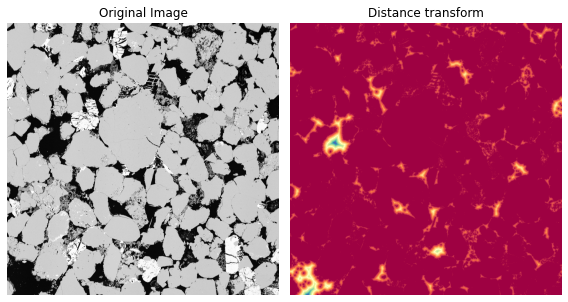

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img_rescale_final[11], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(dt[11], cmap=plt.cm.Spectral)
ax[1].set_title('Distance transform')
ax[1].axis('off')

fig.tight_layout()
plt.show()

### Find peaks or local maxima in the distance transform
The following functions have been copied directly from porespy library in case a modification is required. The objective of applying the following functions to the iamge is to remove the peaks generated in distance transform due to image artifacts or digitization effect. The remaining peaks will be fed into watershed function as seeds. 

In [15]:
import operator as op
import scipy.spatial as sptl
import warnings
from scipy.signal import fftconvolve
from numba import jit
from skimage.segmentation import clear_border
from skimage.morphology import ball, disk, square, cube, diamond, octahedron
from skimage.morphology import reconstruction, watershed
from porespy.tools import randomize_colors, fftmorphology
from porespy.tools import get_border, extend_slice, extract_subsection
from porespy.tools import ps_disk, ps_ball
from porespy.tools import _create_alias_map

def find_peaks(dt, r_max=4, footprint=None):
    r"""
    Returns all local maxima in the distance transform

    Parameters
    ----------
    dt : ND-array
        The distance transform of the pore space.  This may be calculated and
        filtered using any means desired.

    r_max : scalar
        The size of the structuring element used in the maximum filter.  This
        controls the localness of any maxima. The default is 4 voxels.

    footprint : ND-array
        Specifies the shape of the structuring element used to define the
        neighborhood when looking for peaks.  If none is specified then a
        spherical shape is used (or circular in 2D).

    Returns
    -------
    image : ND-array
        An array of booleans with ``True`` values at the location of any
        local maxima.

    Notes
    -----
    It is also possible ot the ``peak_local_max`` function from the
    ``skimage.feature`` module as follows:

    ``peaks = peak_local_max(image=dt, min_distance=r, exclude_border=0,
    indices=False)``

    This automatically uses a square structuring element which is significantly
    faster than using a circular or spherical element.
    """
    im = dt > 0
    if im.ndim != im.squeeze().ndim:
        warnings.warn('Input image conains a singleton axis:' + str(im.shape) +
                      ' Reduce dimensionality with np.squeeze(im) to avoid' +
                      ' unexpected behavior.')
    if footprint is None:
        if im.ndim == 2:
            footprint = disk
        elif im.ndim == 3:
            footprint = ball
        else:
            raise Exception("only 2-d and 3-d images are supported")
    mx = spim.maximum_filter(dt + 2*(~im), footprint=footprint(r_max))
    peaks = (dt == mx)*im
    return peaks

def trim_saddle_points(peaks, dt, max_iters=10):
    r"""
    Removes peaks that were mistakenly identified because they lied on a
    saddle or ridge in the distance transform that was not actually a true
    local peak.

    Parameters
    ----------
    peaks : ND-array
        A boolean image containing True values to mark peaks in the distance
        transform (``dt``)

    dt : ND-array
        The distance transform of the pore space for which the true peaks are
        sought.

    max_iters : int
        The maximum number of iterations to run while eroding the saddle
        points.  The default is 10, which is usually not reached; however,
        a warning is issued if the loop ends prior to removing all saddle
        points.

    Returns
    -------
    image : ND-array
        An image with fewer peaks than the input image

    References
    ----------
    [1] Gostick, J. "A versatile and efficient network extraction algorithm
    using marker-based watershed segmenation".  Physical Review E. (2017)

    """
    peaks = np.copy(peaks)
    if dt.ndim == 2:
        from skimage.morphology import square as cube
    else:
        from skimage.morphology import cube
    labels, N = spim.label(peaks)
    slices = spim.find_objects(labels)
    for i in range(N):
        s = extend_slice(s=slices[i], shape=peaks.shape, pad=10)
        peaks_i = labels[s] == i+1
        dt_i = dt[s]
        im_i = dt_i > 0
        iters = 0
        peaks_dil = np.copy(peaks_i)
        while iters < max_iters:
            iters += 1
            peaks_dil = spim.binary_dilation(input=peaks_dil,
                                             structure=cube(3))
            peaks_max = peaks_dil*np.amax(dt_i*peaks_dil)
            peaks_extended = (peaks_max == dt_i)*im_i
            if np.all(peaks_extended == peaks_i):
                break  # Found a true peak
            elif np.sum(peaks_extended*peaks_i) == 0:
                peaks_i = False
                break  # Found a saddle point
        peaks[s] = peaks_i
        if iters >= max_iters:
            pass
            #print('Maximum number of iterations reached, consider'
            #      + 'running again with a larger value of max_iters')
    return peaks



def trim_nearby_peaks(peaks, dt):
    r"""
    Finds pairs of peaks that are nearer to each other than to the solid phase,
    and removes the peak that is closer to the solid.

    Parameters
    ----------
    peaks : ND-array
        A boolean image containing True values to mark peaks in the distance
        transform (``dt``)

    dt : ND-array
        The distance transform of the pore space for which the true peaks are
        sought.

    Returns
    -------
    image : ND-array
        An array the same size as ``peaks`` containing a subset of the peaks
        in the original image.

    Notes
    -----
    Each pair of peaks is considered simultaneously, so for a triplet of peaks
    each pair is considered.  This ensures that only the single peak that is
    furthest from the solid is kept.  No iteration is required.

    References
    ----------
    [1] Gostick, J. "A versatile and efficient network extraction algorithm
    using marker-based watershed segmenation".  Physical Review E. (2017)
    """
    peaks = np.copy(peaks)
    if dt.ndim == 2:
        from skimage.morphology import square as cube
    else:
        from skimage.morphology import cube
    peaks, N = spim.label(peaks, structure=cube(3))
    crds = spim.measurements.center_of_mass(peaks, labels=peaks,
                                            index=np.arange(1, N+1))
    crds = np.vstack(crds).astype(int)  # Convert to numpy array of ints
    # Get distance between each peak as a distance map
    tree = sptl.cKDTree(data=crds)
    temp = tree.query(x=crds, k=2)
    nearest_neighbor = temp[1][:, 1]
    dist_to_neighbor = temp[0][:, 1]
    del temp, tree  # Free-up memory
    dist_to_solid = dt[tuple(crds.T)]  # Get distance to solid for each peak
    hits = np.where(dist_to_neighbor < dist_to_solid)[0]
    # Drop peak that is closer to the solid than it's neighbor
    drop_peaks = []
    for peak in hits:
        if dist_to_solid[peak] < dist_to_solid[nearest_neighbor[peak]]:
            drop_peaks.append(peak)
        else:
            drop_peaks.append(nearest_neighbor[peak])
    drop_peaks = np.unique(drop_peaks)
    # Remove peaks from image
    slices = spim.find_objects(input=peaks)
    for s in drop_peaks:
        peaks[slices[s]] = 0
    return (peaks > 0)

### Find peaks in the distance transform and apply watershed segmentation

#### Find peaks from medial axis
1) Calculate the distance map, 
2) Extract skeleton (medial axis), 
3) Mask the distance map with skeleton, 
4) Find local maxima in the masked distance transform and use them as markers


In [16]:
def find_peaks_from_skel(dt, skel, r_max=4, footprint=None):
    r"""
    Returns all local maxima in the distance transform

    Parameters
    ----------
    dt : ND-array
        The distance transform of the pore space.  This may be calculated and
        filtered using any means desired.

    r_max : scalar
        The size of the structuring element used in the maximum filter.  This
        controls the localness of any maxima. The default is 4 voxels.

    footprint : ND-array
        Specifies the shape of the structuring element used to define the
        neighborhood when looking for peaks.  If none is specified then a
        spherical shape is used (or circular in 2D).

    Returns
    -------
    image : ND-array
        An array of booleans with ``True`` values at the location of any
        local maxima.

    Notes
    -----
    It is also possible ot the ``peak_local_max`` function from the
    ``skimage.feature`` module as follows:

    ``peaks = peak_local_max(image=dt, min_distance=r, exclude_border=0,
    indices=False)``

    This automatically uses a square structuring element which is significantly
    faster than using a circular or spherical element.
    """
    im = dt > 0
    if im.ndim != im.squeeze().ndim:
        warnings.warn('Input image conains a singleton axis:' + str(im.shape) +
                      ' Reduce dimensionality with np.squeeze(im) to avoid' +
                      ' unexpected behavior.')
    if footprint is None:
        if im.ndim == 2:
            footprint = disk
        elif im.ndim == 3:
            footprint = ball
        else:
            raise Exception("only 2-d and 3-d images are supported")
    dt_bg = skel*dt
    mx = spim.maximum_filter(dt_bg + 2*(~im), footprint=footprint(r_max))
    peaks = (dt == mx)*im
    return peaks


#### Perform watershed segmentation

In [17]:
def perform_watershed(dt, sigma=0.4, iters=1000):
    
    
    reduced_peaks = []
    seg_regions = []
    for i in tqdm(range(len(dt))):
        dt1 = spim.gaussian_filter(input=dt[i], sigma=sigma)
        peaks = find_peaks(dt1)
        #print('Initial number of peaks: ', spim.label(peaks)[1])
        peaks = trim_saddle_points(peaks=peaks, dt=dt1, max_iters=iters)
        #print('Peaks after trimming saddle points: ', spim.label(peaks)[1])
        peaks = trim_nearby_peaks(peaks=peaks, dt=dt1)
        peaks, N = spim.label(peaks)
        #print('Peaks in image {} after trimming nearby peaks: '.format(i+1), N)
        
        regions = watershed(image=-dt[i], markers=peaks, mask=dt[i]> 0)
        regions = randomize_colors(regions)
        
        reduced_peaks.append(peaks)
        seg_regions.append(regions)
        
        
    return seg_regions, reduced_peaks


In [18]:
regions,peaks = perform_watershed(dt, sigma=0.4, iters=1000)

100%|██████████| 12/12 [01:53<00:00,  9.49s/it]


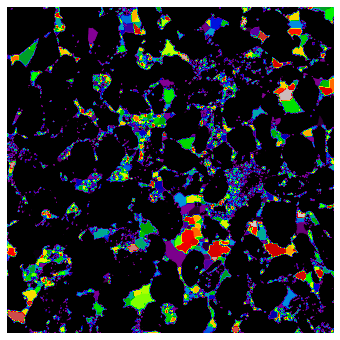

In [38]:
# Visualize the regions
plt.figure(figsize=(6, 6))
plt.imshow((regions[2]*Pores[2]), cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.show()

# Measure and Analysis

### Region properties
The main function in python skimage library for calculating the proprties of labeled images is measure.regionprops. There is also another function that returns the calculations in a table which is called "regionprops_table". Here I first apply the regionprops on just one single image to get an idea of what properties are returned. Then, I use regionprops_table to return some specific properties in a table which I then convert to dataframe and concatenate.

In [19]:
from skimage.measure import regionprops, regionprops_table

props = regionprops(regions[0]*Pores[0])

In [20]:
r = props[0]
attrs = [a for a in r.__dir__() if not a.startswith('_')]
print(attrs)

['label', 'slice', 'area', 'bbox', 'bbox_area', 'centroid', 'convex_area', 'convex_image', 'coords', 'eccentricity', 'equivalent_diameter', 'euler_number', 'extent', 'filled_area', 'filled_image', 'image', 'inertia_tensor', 'inertia_tensor_eigvals', 'intensity_image', 'local_centroid', 'max_intensity', 'mean_intensity', 'min_intensity', 'major_axis_length', 'minor_axis_length', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'solidity', 'weighted_centroid', 'weighted_local_centroid', 'weighted_moments', 'weighted_moments_central', 'weighted_moments_hu', 'weighted_moments_normalized']


In [21]:
import pandas as pd
from skimage.measure import regionprops, regionprops_table

def property_extract(bool_img, regions, scales):
    
    '''
    Calculates properties using the regionprops function of simage and returns an appended dataframe and applies
    the scales read for every image from dm4 file to the properties
    scales is a vector of magnifications in micron/pixels unit
    '''

    Appended_df = []
    for i in tqdm(range(len(regions))):
        dt = regionprops_table(regions[i], bool_img[i], properties=['label', 'area', 'equivalent_diameter'])
        df = pd.DataFrame(dt)
        df['area'] = df['area'] * scales[i]**2
        df['equivalent_diameter'] = df['equivalent_diameter'] * scales[i]
        #df['perimeter'] = df['perimeter'] * scales[i]
        df.insert(0, 'Image', i+1)
        
        Appended_df.append(df)

    Appended_df = pd.concat(Appended_df)
    
    return Appended_df

In [22]:
properties = property_extract(Pores,regions,scales_img)

100%|██████████| 12/12 [00:03<00:00,  3.25it/s]


In [23]:
properties.head()

,Image,label,area,equivalent_diameter
0,1,1,22.580631,5.361954
1,1,2,40.875887,7.214208
2,1,3,40.546243,7.185059
3,1,4,31.975492,6.380632
4,1,5,24.888141,5.629260


In [24]:
properties[['area','equivalent_diameter']].describe()

,area,equivalent_diameter
count,59679.000000,59679.000000
mean,98.992705,7.851632
std,320.017240,8.024611
min,0.164822,0.458103
25%,8.076284,3.206719
50%,22.250987,5.322672
75%,68.236360,9.321010
max,18864.056971,154.978912


# Pore and Grain Size Distribution

### Normalized Area Fraction

In [25]:
def area_weighted(diameters, areas, binsize='auto', **fig_kw):
    """ Generates an area-weighted histogram and returns different
    area-weighted statistics.
    Parameters
    ----------
    diameters : array_like
        the size of the pores or grains
    areas : array_like
        the sectional areas of the pores or grains
    binsize : string or positive scalar, optional
        If 'auto', it defines the plug-in method to calculate the bin size.
        When integer or float, it directly specifies the bin size.
        Default: the 'auto' method.
        | Available plug-in methods:
        | 'auto' (fd if sample_size > 1000 or Sturges otherwise)
        | 'doane' (Doane's rule)
        | 'fd' (Freedman-Diaconis rule)
        | 'rice' (Rice's rule)
        | 'scott' (Scott rule)
        | 'sqrt' (square-root rule)
        | 'sturges' (Sturge's rule)
    **fig_kw :
        additional keyword arguments to control the size (figsize) and
        resolution (dpi) of the plot. Default figsize is (6.4, 4.8).
        Default resolution is 100 dpi.
    Examples
    --------
    >>> area_weighted(data['diameters'], data['Areas'])
    >>> area_weighted(data['diameters'], data['Areas'], binsize='doane', dpi=300)
    """

    # estimate weighted mean
    area_total = np.sum(areas)
    weighted_areas = areas / area_total
    weighted_mean = np.sum(diameters * weighted_areas)

    # estimate mode interval
    if type(binsize) is str:
        histogram, bin_edges = np.histogram(diameters, bins=20, range=(0.0, diameters.max()))
        h = bin_edges[1]
    else:
        bin_edges = np.arange(0.0, diameters.max() + binsize, binsize)
        h = binsize

    # estimate the cumulative areas of each pore or grain size interval
    cumulativeAreas = np.zeros(len(bin_edges))
    for index, values in enumerate(bin_edges):
        mask = np.logical_and(diameters >= values, diameters < (values + h))
        area_sum = np.sum(areas[mask])
        cumulativeAreas[index] = round(area_sum, 1)

    # get the index of the modal interval
    getIndex = np.argmax(cumulativeAreas)

    print('=======================================')
    print('DESCRIPTIVE STATISTICS')
    print('Area-weighted mean pore or grain size = {:0.2f} microns' .format(weighted_mean))
    print('=======================================')
    print('HISTOGRAM FEATURES')
    print('The modal interval is {left:0.2f} - {right:0.2f} microns' .format(left=bin_edges[getIndex],
                                                                             right=bin_edges[getIndex] + h))
    print('The number of classes are {}' .format(len(histogram)))
    if type(binsize) is str:
        print('The bin size is {bin:0.2f} according to the {rule} rule' .format(bin=h, rule=binsize))
    print('=======================================')

    # normalize the y-axis values to percentage of the total area
    totalArea = sum(cumulativeAreas)
    cumulativeAreasNorm = [(x / float(totalArea))*100 for x in cumulativeAreas]
    maxValue = max(cumulativeAreasNorm)

    return bin_edges, cumulativeAreasNorm

## Density Plot

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gaussian_kde, shapiro, iqr


# plotting funtions
def distribution(data,
                 plot=('hist', 'kde'),
                 avg=('amean', 'gmean', 'median', 'mode'),
                 binsize='auto',
                 #bandwidth='silverman',
                 **fig_kw):
    """ Return a plot with the ditribution of (apparent or actual) grain sizes
    in a dataset.
    Parameters
    ----------
    data : array_like
        the size of the grains
    plot : string, tuple or list; optional
        the type of plot, either histogram ('hist'), kernel density estimate
        ('kde') or both ('hist', 'kde'). Default is both.
    avg : string, tuple or list; optional
        the central tendency measures o show, either the arithmetic ('amean')
        or geometric ('gmean') means, the median ('median'), and/or the
        KDE-based mode ('mode'). Default all averages.
    binsize : string or positive scalar; optional
        If 'auto', it defines the plug-in method to calculate the bin size.
        When integer or float, it directly specifies the bin size.
        Default: the 'auto' method.
        | Available plug-in methods:
        | 'auto' (fd if sample_size > 1000 or Sturges otherwise)
        | 'doane' (Doane's rule)
        | 'fd' (Freedman-Diaconis rule)
        | 'rice' (Rice's rule)
        | 'scott' (Scott rule)
        | 'sqrt' (square-root rule)
        | 'sturges' (Sturge's rule)
    bandwidth : string {'silverman' or 'scott'} or positive scalar; optional
        the method to estimate the bandwidth or a scalar directly defining the
        bandwidth. It uses the Silverman plug-in method by default.
    **fig_kw :
        additional keyword arguments to control the size (figsize) and
        resolution (dpi) of the plot. Default figsize is (6.4, 4.8).
        Default resolution is 100 dpi.
    Call functions
    --------------
    - gaussian_kde (from Scipy stats)
    Examples
    --------
    >>> distribution(data['diameters'])
    >>> distribution(data['diameters'], figsize=(6.4, 4.8))
    Returns
    -------
    A plot showing the distribution of (apparent) grain sizes and
    the location of the averages defined.
    """

    fig, ax = plt.subplots(**fig_kw)

    if 'hist' in plot:
        if isinstance(binsize, (int, float)):
            binsize = binsize
            
        y_values, bins = np.histogram(data,
                                     bins=binsize,
                                     range=(data.min(), data.max()), 
                                     density=True)
        

        print('=======================================')
        print('Number of classes = ', len(bins) - 1)
        print('binsize = ', round(bins[1] - bins[0], 2))
        print('=======================================')
        left_edges = np.delete(bins, -1)
        h = bins[1] - bins[0]
        ax.bar(left_edges, y_values,
                width=h,
                color='xkcd:azure',
                edgecolor='#d9d9d9',
                align='edge')

    if 'kde' in plot:
        # estimate kde first
        if isinstance(bandwidth, (int, float)):
            fixed_bw = bandwidth / np.std(data, ddof=1)
            kde = gaussian_kde(data, bw_method=fixed_bw)
        elif isinstance(bandwidth, str):
            kde = gaussian_kde(data, bw_method=bandwidth)
            bandwidth = round(kde.covariance_factor() * data.std(ddof=1), 2)
        else:
            raise ValueError("bandwidth must be integer, float, or plug-in methods 'silverman' or 'scott'")

        x_values = np.linspace(data.min(), data.max(), num=1000)
        y_values = kde(x_values)

        print('=======================================')
        print('KDE bandwidth = ', round(bandwidth, 2))
        print('=======================================')

        if 'hist' in plot:
            ax.plot(x_values, y_values,
                    color='#2F4858')
        else:
            ax.plot(x_values, y_values,
                    color='#2F4858')
            ax.fill_between(x_values, y_values,
                            color='#80419d',
                            alpha=0.65)

    # plot the location of the averages
    if 'amean' in avg:
        amean = np.mean(data)
        ax.vlines(amean, 0, np.max(y_values),
                  linestyle='solid',
                  color='#2F4858',
                  label='arith. mean',
                  linewidth=2.5)
        print('=======================================')
        print('amean = ', round(amean, 2))
        print('=======================================')

    if 'gmean' in avg:
        gmean = np.exp(np.mean(np.log(data)))
        ax.vlines(gmean, 0, np.max(y_values),
                  linestyle='solid',
                  color='#fec44f',
                  label='geo. mean')
        print('=======================================')
        print('gmean = ', round(gmean, 2))
        print('=======================================')

    if 'median' in avg:
        median = np.median(data)
        ax.vlines(median, 0, np.max(y_values),
                  linestyle='dashed',
                  color='#2F4858',
                  label='median',
                  linewidth=2.5)
        print('=======================================')
        print('median = ', round(median, 2))
        print('=======================================')

    if 'mode' in avg and 'kde' in plot:
        mode = x_values[np.argmax(y_values)]
        ax.vlines(mode, 0, np.max(y_values),
                  linestyle='dotted',
                  color='#2F4858',
                  label='mode',
                  linewidth=2.5)
        print('=======================================')
        print('mode = ', round(mode, 2))
        print('=======================================')

    ax.set_ylabel('density', color='#252525')
    ax.set_xlabel(r'apparent diameter ($\mu m$)', color='#252525')
    ax.set_xscale('linear')
    ax.legend(loc='best', fontsize=16)
#    ax.set_ylim(bottom=-0.001)

    fig.tight_layout()

    return fig, ax

# Stereology
From 2D to 3D distribution

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def Saltykov(diameters, areas, numbins=10, calc_vol=None, text_file=None,
             return_data=False, left_edge=0):
    """ Estimate the actual (3D) distribution of grain size from the population
    of apparent diameters measured in a thin section using a Saltykov-type
    algorithm (Saltykov 1967; Sahagian and Proussevitch 1998).
    The Saltykov method is optimal to estimate the volume of a particular grain
    size fraction as well as to obtain a qualitative view of the appearance of
    the actual 3D grain size population, either in uni- or multimodal populations.
    Parameters
    ----------
    diameters : array_like
        the apparent diameters of the grains.
    numbins : positive integer, optional
        the number of bins/classes of the histogram. If not declared,
        is set to 10 by default.
    calc_vol : positive scalar or None, optional
        if the user specifies a diameter, the function will return the volume
        occupied by the grain fraction up to that diameter.
    text_file : string or None, optional
        if the user specifies a name, the function will store a csv file
        with that name containing the Saltykov output.
    return_data : bool, optional
       if True the function will return the position of the midpoints and
       the frequencies.
    left_edge : positive scalar or 'min', optional
        set the left edge of the histogram. Default is zero.
    Call functions
    --------------
    - unfold_population
    - Saltykov_plot
    Examples
    --------
    >>> Saltykov(diameters)
    >>> Saltykov(diameters, numbins=16, calc_vol=40)
    >>> Saltykov(diameters, text_file='foo.csv')
    >>> mid_points, frequencies = Saltykov(diameters, return_data=True)
    References
    ----------
    Saltykov SA (1967) http://doi.org/10.1007/978-3-642-88260-9_31
    Sahagian and Proussevitch (1998) https://doi.org/10.1016/S0377-0273(98)00043-2
    Return
    ------
    Statistical descriptors, a plot, and/or a file with the data (optional)
    """

    if isinstance(numbins, int) is False:
        raise ValueError('Numbins must be a positive integer')
    if numbins <= 0:
        raise ValueError('Numbins must be higher than zero')
    if isinstance(left_edge, (int, float)):
        if left_edge < 0:
            raise ValueError("left_edge must be a positive scalar or 'min'")

    # compute the histogram
    if left_edge == 'min':
        freq, bin_edges = np.histogram(diameters,
                                       bins=numbins,
                                       range=(diameters.min(), diameters.max()),
                                       density=True)
    else:
        freq, bin_edges = np.histogram(diameters,
                                       bins=numbins,
                                       range=(left_edge, diameters.max()),
                                       density=True)
        

    h = bin_edges[1] - bin_edges[0]
    binsize = bin_edges[1] - bin_edges[0]

    # Create an array with the left edges of the bins and other with the midpoints
    left_edges = np.delete(bin_edges, -1)
    mid_points = left_edges + binsize / 2
    
    # estimate the cumulative areas of each pore or grain size interval
    cumulativeAreas = np.zeros(len(mid_points))
    for index, values in enumerate(mid_points):
        mask = np.logical_and(diameters >= values, diameters < (values + h))
        area_sum = np.sum(areas[mask])
        cumulativeAreas[index] = round(area_sum, 1)

    # normalize the y-axis values to percentage of the total area
    totalArea = sum(cumulativeAreas)
    cumulativeAreasNorm = [(x / float(totalArea))*100 for x in cumulativeAreas]



    # Unfold the population of apparent diameters using the Saltykov method
    freq3D = unfold_population(np.array(cumulativeAreasNorm), bin_edges, binsize, mid_points)
    #freq3D = unfold_population(freq, bin_edges, binsize, mid_points)
    # Calculate the volume-weighted cumulative frequency distribution
    # TODO -> better an own function
    x_vol = binsize * (4 / 3.) * np.pi * (mid_points**3)
    freq_vol = x_vol * freq3D
    # normalize the y-axis values to percentage of the total area
    totalVol = sum(freq_vol)
    cumulativeVolNorm = [(x / float(totalVol))*100 for x in freq_vol]
    
    cdf = np.cumsum(freq_vol)
    cdf_norm = 100 * (cdf / cdf[-1])

    # Estimate the volume of a particular grain size fraction (if proceed)
    if calc_vol is not None:
        x, y = mid_points, cdf_norm
        index = np.argmax(mid_points > calc_vol)
        angle = np.arctan((y[index] - y[index - 1]) / (x[index] - x[index - 1]))
        volume = y[index - 1] + np.tan(angle) * (calc_vol - x[index - 1])
        if volume < 100.0:
            print('=======================================')
            print('volume fraction (up to', calc_vol, 'microns) =', round(volume, 2), '%')
            print('=======================================')
        else:
            print('=======================================')
            print('volume fraction (up to', calc_vol, 'microns) =', 100, '%')
            print('=======================================')

    # Create a text file (if apply) with the midpoints, class frequencies, and
    # cumulative volumes
    if text_file is not None:
        from pandas import DataFrame
        if isinstance(text_file, str) is False:
            print('text_file must be None or string type')
        df = DataFrame({'mid_points': np.around(mid_points, 3),
                        'freqs': np.around(freq3D, 4),
                        'freqs2one': np.around(freq3D * binsize, 3),
                        'cum_vol': np.around(cdf_norm, 2)})
        if text_file.endswith('.txt'):
            df.to_csv(text_file, sep='\t')
        elif text_file.endswith('.csv'):
            df.to_csv(text_file, sep=';')
        else:
            raise ValueError('text file must be specified as .csv or .txt')
        print('=======================================')
        print('The file {} was created' .format(text_file))
        print('=======================================')

    # return data or figure (if apply)
    if return_data is True:
        #print('Note: To estimate the proportions relative to one multiply the')
        #print('density values by the bin size, which is: {:0.3f}' .format(binsize))
        #print(' ')
        return left_edges, cumulativeVolNorm, h, mid_points, cdf_norm

    elif return_data is False:
        print('=======================================')
        print('bin size = {:0.2f}' .format(binsize))
        print('=======================================')
        return Saltykov_plot(left_edges, cumulativeVolNorm, binsize, mid_points, cdf_norm)

    else:
        raise TypeError('return_data must be set as True or False')


def calc_shape(diameters, class_range=(10, 20)):
    """ Approximates the shape of the actual (3D) distribution of grain size
    from a population of apparent diameters measured in a thin section using
    the two-step method (Lopez-Sanchez and Llana-Funez, 2016).
    The method only works properly for unimodal lognormal-like grain size
    populations and returns the MSD (i.e. shape) and the geometric mean
    (i.e. scale) values, which describe the lognormal population of grain sizes
    at their original (linear) scale.
    Parameters
    ----------
    diameters : array_like
        the apparent diameters of the grains
    class_range : tupe or list with two values, optional
        the range of classes considered. The algorithm will estimate the optimal
        number of classes within the defined range. Default = (10, 20)
    Call functions
    --------------
    - Saltykov,
    - fit_log,
    - log_function
    - gen_xgrid
    - twostep_plot
    Examples
    --------
    >>> calc_shape(diameters)
    >>> calc_shape(diameters, class_range=(12, 18))
    >>> calc_shape(diameters, initial_guess=True)
    References
    ----------
    Saltykov SA (1967) http://doi.org/10.1007/978-3-642-88260-9_31
    Sahagian and Proussevitch (1998) https://doi.org/10.1016/S0377-0273(98)00043-2
    Lopez-Sanchez and Llana-Funez (2016) https://doi.org/10.1016/j.jsg.2016.10.008
    Returns
    -------
    A plot with an estimate of the actual (3D) grains size distribution and
    several statistical parameters
    """

    # estimate the prior shape and scale based on the apparent distribution
    shape = np.exp(np.std(np.log(diameters), ddof=1))
    scale = np.median(diameters)

    # estimate the number of classes that produces the best fit within the range defined
    class_list = list(range(class_range[0], class_range[1] + 1))
    stds = np.zeros(len(class_list))

    for index, item in enumerate(class_list):
        mid_points, frequencies = Saltykov(diameters, areas, numbins=item, return_data=True)
        optimal_params, sigma_error = fit_log(mid_points, frequencies, initial_guess=(shape, scale))
        stds[index] = sigma_error[0]

    # get the optimal number of clases and estimate the best fit parameters
    optimal_num_classes = class_list[np.argmin(stds)]
    mid_points, frequencies = Saltykov(diameters, areas, numbins=optimal_num_classes, return_data=True)
    optimal_params, sigma_err = fit_log(mid_points, frequencies, (shape, scale))

    print('=======================================')
    print('PREDICTED OPTIMAL VALUES')
    print('Number of classes: {}' .format(optimal_num_classes))
    print('MSD (lognormal shape) = {msd:0.2f} ± {err:0.2f}'
          .format(msd=optimal_params[0], err=3 * sigma_err[0]))
    print('Geometric mean (scale) = {gmean:0.2f} ± {err:0.2f}'
          .format(gmean=optimal_params[1], err=3 * sigma_err[1]))
    print('=======================================')
    # print(' Covariance matrix:\n', covm)

    # prepare data for the plot
    xgrid = np.linspace(0.1, diameters.max(), 1000)
    best_fit = log_function(xgrid, optimal_params[0], optimal_params[1])

    # Estimate all the combinatorial posibilities for fit curves taking into account the uncertainties
    values = np.array([log_function(xgrid, optimal_params[0] + sigma_err[0], optimal_params[1] + sigma_err[1]),
                       log_function(xgrid, optimal_params[0] - sigma_err[0], optimal_params[1] - sigma_err[1]),
                       log_function(xgrid, optimal_params[0] + sigma_err[0], optimal_params[1] - sigma_err[1]),
                       log_function(xgrid, optimal_params[0] - sigma_err[0], optimal_params[1] + sigma_err[1])])

    # Estimate the standard deviation of the all values obtained
    fit_error = np.std(values, axis=0)

    return twostep_plot(xgrid, mid_points, frequencies, best_fit, fit_error)


def unfold_population(freq, bin_edges, binsize, mid_points, normalize=True):
    """ Applies the Saltykov-type algorithm to unfold the population of apparent
    (2D) diameters into the actual (3D) population of grain sizes. Following the
    reasoning of Higgins (2000), R (or D) is placed at the center of the classes
    (i.e. the midpoints).
    Reference
    ----------
    Higgins (2000) doi:10.2138/am-2000-8-901
    Saltykov SA (1967) http://doi.org/10.1007/978-3-642-88260-9_31
    Sahagian and Proussevitch (1998) https://doi.org/10.1016/S0377-0273(98)00043-2
    Parameters
    ----------
    freq : array_like
        frequency values of the different classes
    bin_edges : array_like
        the edges of the classes
    mid_points : array_like
        the midpoints of the classes
    normalize : boolean, optional
        when True negative frequency values are set to zero and the
        distribution normalized. True by default.
    Call function
    -------------
    - wicksell_eq
    Returns
    -------
    The normalized frequencies of the unfolded population such that the integral
    over the range is one. If normalize is False the raw frequencies of the
    unfolded population.
    """

    d_values = np.copy(bin_edges)
    midpoints = np.copy(mid_points)
    i = len(midpoints) - 1

    while i > 0:
        j = i
        D = d_values[-1]
        Pi = wicksell_solution(D, d_values[i], d_values[i + 1])

        if freq[i] > 0:
            while j > 0:
                D = midpoints[-1]
                Pj = wicksell_solution(D, d_values[j - 1], d_values[j])
                P_norm = (Pj * freq[i]) / Pi
                np.put(freq, j - 1, freq[j - 1] - P_norm)  # replace specified elements of an array
                j -= 1

            i -= 1
            d_values = np.delete(d_values, -1)
            midpoints = np.delete(midpoints, -1)

        # if the value of the current class is zero or negative move to the next class
        else:
            i -= 1
            d_values = np.delete(d_values, -1)
            midpoints = np.delete(midpoints, -1)

    if normalize is True:
        freq = np.clip(freq, a_min=0.0, a_max=None)  # replacing negative values with zero
        freq_norm = freq / sum(freq)  # normalize to one
        freq_norm = freq_norm / binsize  # normalize such that the integral over the range is one
        return freq_norm

    else:
        return freq


def wicksell_solution(D, d1, d2):
    """ Estimate the cross-section size probability for a discretized population
    of spheres based on the Wicksell (1925) and later on Scheil (1931),
    Schwartz (1934) and Saltykov (1967). This is:
    P(r1 < r < r2) = 1/R * (sqrt(R**2 - r1**2) - sqrt(R**2 - r2**2))
    where R is the sphere radius and r the cross-section radius.
    r1 and r2 are the lower and upper bounds of the classes, respectively.
    R can be placed at the at the center or the upper/lower limit of the
    classes.
    Parameters
    ----------
    D: positive scalar
        the midpoint of the actual class
    d1: positive scalar
        the lower limit of the bin/class
    d2: positive scalar
        the upper limit of the bin/class
    References
    ----------
    | Saltykov (1967) doi:10.1007/978-3-642-88260-9_31
    | Scheil (1931) doi:10.1002/zaac.19312010123
    | Schwartz (1934) Met. Alloy 5:139
    | Wicksell (1925) doi:10.2307/2332027
    | Higgins (2000) doi:10.2138/am-2000-8-901
    Returns
    -------
    the cross-section probability for a especific range of grain size
    """

    # convert diameters to radii
    R, r1, r2 = D / 2, d1 / 2, d2 / 2

    return 1 / R * (np.sqrt(R**2 - r1**2) - np.sqrt(R**2 - r2**2))


# ============================================================================ #
# AUXILIARY FUNCTIONS                                                          #
# ============================================================================ #


def fit_log(x, y, initial_guess):
    """ Fit a lognormal distribution to data. It uses the curve_fit
    scipy routine, which is a non-linear least-square implementation of
    the Levenberge-Marquardt algorithm.
    Parameters
    ----------
    x : array-like
        the x coordinates of the points
    y : array-like
        the y coordinates of the points
    initial_guess : tuple or list with two values
        a tuple or list with the two starting guess values
    Assumptions
    -----------
    - the distribution of points approach a lognormal distribution.
    - It is assumed that the multiplicative SD lies within the range
    from 1 (gaussian) to 10.
    Call functions
    --------------
    log_function
    curve_fit (from Scipy)
    Returns
    -------
    The optimal params and the error of the fit
    """
    # fit a log normal function (it assumes that shape is within the 1-10 range
    # and location is positive)
    optimal_params, cov_matrix = curve_fit(log_function, x, y, initial_guess,
                                           bounds=((1, 0), (10, np.inf)))

    # estimate the uncertainty of the fit.
    sigma_error = np.sqrt(np.diag(cov_matrix))

    return optimal_params, sigma_error


def log_function(x, shape, scale):
    """ This is the two-parameter equation that describes a lognormal
    distribution using the mean and the standard deviation of the
    log(x) with base e.
    Parameters
    ----------
    x: array_like
        the x-values
    shape: positive scalar
        the shape parameter; it relates to the sigma parameter: s = log(shape)
    scale: positive scalar
        the scale parameter; it relates to the mean of log(x): m = log(scale)
    """

    s = np.log(shape)
    m = np.log(scale)

    return 1 / (x * s * np.sqrt(2 * np.pi)) * np.exp(-1 / 2. * ((np.log(x) - m)**2 / s**2))


def gen_xgrid(start, stop, precision):
    """ Returns a mesh of values (i.e. discretize the
    sample space) with a fixed range and desired precision.
    Parameters
    ----------
    start : scalar
        the starting value of the sequence
    stop : scalar
        the end value of the sequence
    precision : scalar, int or float
        the desired precision (density) of the mesh
    """

    rango = stop - start

    # num = range / precision; as long as range > precision
    if rango < precision:
        raise ValueError('The precision must be smaller than the range of grain sizes')
    else:
        n = int(round(rango / precision, 0))

    return np.linspace(start, stop, num=n)


def Saltykov_plot(left_edges, freq3D, binsize, mid_points, cdf_norm):
    """ Generate two plots once the Saltykov method is applied:
    i)  a bar plot (ax1)
    ii) a volume-weighted cumulative frequency plot (ax2)
    """

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # frequency vs grain size plot
    ax1.bar(left_edges, freq3D,
            width=binsize,
            color='xkcd:azure',
            edgecolor='#d9d9d9',
            align='edge')
    ax1.set_ylabel('density',
                   fontsize=18)
    ax1.set_xlabel(r'log(diameter) ($\mu m$)',
                   fontsize=18)
    # ax1.set_title('estimated 3D grain size distribution',
    #               color='#1F1F1F',
    #               fontsize=18,
    #               y=1.02)

    # volume-weighted cumulative frequency curve
    ax2.set_ylim([-2, 105])
    ax2.plot(mid_points, cdf_norm,
             'o-',
             color='#ed4256',
             label='volume weighted CFD',
             linewidth=2)
    ax2.set_ylabel('cumulative volume (%)',
                   color='#252525')
    ax2.set_xlabel(r'log(diameter) ($\mu m$)',
                   color='#252525')
    # ax2.set_title('volume-weighted cumulative freq. distribution',
    #               color='#1F1F1F',
    #               fontsize=18,
    #               y=1.02)

    fig.tight_layout()

    return fig, (ax1, ax2)


def twostep_plot(xgrid, mid_points, frequencies, best_fit, fit_error):
    """ Generate a plot with the best fitting lognormal distribution (two-step method)"""

    # matplotlib stuff
    fig, ax = plt.subplots()

    # bar plot from Saltykov method
    ax.bar(mid_points, frequencies,
           width=mid_points[1] - mid_points[0],
           edgecolor='#1F1F1F',
           hatch='//',
           color='#fff2ae',
           fill=False,
           linewidth=1,
           label='Saltykov method',
           alpha=0.65)

    # log-normal distribution
    ax.plot(xgrid, best_fit,
            color='#2F4858',
            label='best lognormal fit',
            linewidth=2)

    ax.fill_between(xgrid, best_fit,
                    color='xkcd:azure',
                    alpha=0.65)

#    ax.fill_between(xgrid, best_fit + (3 * fit_error), best_fit - (3 * fit_error),
#                    color='#525252',
#                    label='trust region',
#                    alpha=0.5)

#    ax.plot(mid_points, frequencies,  # datapoints used for the fitting procedure
#            'o',
#            color='#d53e4f',
#            label='datapoints',
#            linewidth=1.5)

    ax.set_ylabel('freq. (per unit vol.)', color='#252525')
    ax.legend(loc='best', fontsize=15)
    ax.set_xlabel(r'diameter ($\mu m$)', color='#252525')

    fig.tight_layout()

    return fig, ax


if __name__ == '__main__':
    pass
else:
    print('module stereology imported')

### Normalized Volume Fraction

In [43]:
def volume_weighted(diameters, volumes, binsize=20, **fig_kw):
    """ Generates an area-weighted histogram and returns different
    area-weighted statistics.
    Parameters
    ----------
    diameters : array_like
        the size of the pores or grains
    volumes : array_like
        the volumes of the pores or grains
    binsize : string or positive scalar, optional
        If 'auto', it defines the plug-in method to calculate the bin size.
        When integer or float, it directly specifies the bin size.
        Default: the 'auto' method.
        | Available plug-in methods:
        | 'auto' (fd if sample_size > 1000 or Sturges otherwise)
        | 'doane' (Doane's rule)
        | 'fd' (Freedman-Diaconis rule)
        | 'rice' (Rice's rule)
        | 'scott' (Scott rule)
        | 'sqrt' (square-root rule)
        | 'sturges' (Sturge's rule)
    **fig_kw :
        additional keyword arguments to control the size (figsize) and
        resolution (dpi) of the plot. Default figsize is (6.4, 4.8).
        Default resolution is 100 dpi.
    Examples
    --------
    >>> volume_weighted(data['diameters'], data['Volume'])
    >>> volume_weighted(data['diameters'], data['Volume'], binsize='doane', dpi=300)
    """

    # estimate weighted mean
    volume_total = np.sum(volumes)
    weighted_areas = volumes / volume_total
    weighted_mean = np.sum(diameters * weighted_areas)


    histogram, bin_edges = np.histogram(diameters, bins=binsize, range=(0.0, diameters.max()))
    h = bin_edges[1]


    # estimate the cumulative areas of each pore or grain size interval
    cumulativeVolumes = np.zeros(len(bin_edges))
    for index, values in enumerate(bin_edges):
        mask = np.logical_and(diameters >= values, diameters < (values + h))
        volume_sum = np.sum(volumes[mask])
        cumulativeVolumes[index] = round(volume_sum, 1)

    # get the index of the modal interval
    getIndex = np.argmax(cumulativeVolumes)

    print('=======================================')
    print('DESCRIPTIVE STATISTICS')
    print('Volume-weighted mean pore or grain size = {:0.2f} microns' .format(weighted_mean))
    print('=======================================')
    print('HISTOGRAM FEATURES')
    print('The modal interval is {left:0.2f} - {right:0.2f} microns' .format(left=bin_edges[getIndex],
                                                                             right=bin_edges[getIndex] + h))
    print('The number of classes are {}' .format(len(histogram)))
    if type(binsize) is str:
        print('The bin size is {bin:0.2f} according to the {rule} rule' .format(bin=h, rule=binsize))
    print('=======================================')

    # normalize the y-axis values to percentage of the total area
    totalVolume = sum(cumulativeVolumes)
    cumulativeVolumesNorm = [(x / float(totalVolume))*100 for x in cumulativeVolumes]
    maxValue = max(cumulativeVolumesNorm)

    return bin_edges, cumulativeVolumesNorm, h

## Q-Q Plot

In [115]:
def qq_plot(data_SEM, data_CT, percent=2, **fig_kw):
    """ Test whether the underlying distribution follows a lognormal
    distribution using a quantile–quantile (q-q) plot and a Shapiro-
    Wilk test.

    Parameters
    ----------
    data : array-like
        the apparent diameters or any other type of data

    percent : scalar between 0 and 100
        the percentil interval to estimate, default is 2 %

    Call functions
    --------------
    shapiro from scipy's stats
    """

    data_SEM = np.sort(np.log(data_SEM))
    data_CT = np.sort(np.log(data_CT))
    # estimate percentiles in the actual data
    percentil = np.arange(1, 100, percent)
    actual_data_SEM = np.percentile(data_SEM, percentil)
    actual_data_CT = np.percentile(data_CT, percentil)


    # estimate percentiles for theoretical data
    mean_SEM, std_SEM = np.mean(data_SEM), np.std(data_SEM)
    mean_CT, std_CT = np.mean(data_CT), np.std(data_CT)
    
    theoretical_data_SEM = norm.ppf(percentil / 100, loc=mean_SEM, scale=std_SEM)
    theoretical_data_CT = norm.ppf(percentil / 100, loc=mean_CT, scale=std_CT)
    
    min_val_SEM, max_val_SEM = theoretical_data_SEM.min(), theoretical_data_SEM.max()
    min_val_CT, max_val_CT = theoretical_data_CT.min(), theoretical_data_CT.max()

    
    # make the plot
    fig, ax = plt.subplots(**fig_kw)

    ax.plot([min_val_SEM, max_val_SEM], [min_val_SEM, max_val_SEM],
            '-',
            color='black',
            label='Perfect lognormal')
    ax.plot([min_val_CT, max_val_CT], [min_val_CT, max_val_CT],
        '-',
        color='black')
    ax.plot(actual_data_SEM, theoretical_data_SEM,
            'o',
            color='blue',
            label = 'SEM',
            alpha=None)
    ax.plot(actual_data_CT, theoretical_data_CT,
            '^',
            color='lime',
            label = 'CT',
            alpha=None)
    
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    ax.set_xlabel('Observed', color='black')
    ax.set_ylabel('Theoretical', color='black')
    ax.legend(loc='best', fontsize=12)
    # ax.set_aspect('equal')

    fig.tight_layout()
'''
# Shapiro-Wilk test
    if len(data) > 250:
        W, p_value = shapiro(np.random.choice(data, size=250))
    else:
        W, p_value = shapiro(data)
    print('=======================================')
    print('Shapiro-Wilk test (lognormal):')
    print('{:0.2f}, {:0.2f} (test statistic, p-value)' .format(W, p_value))
    if p_value >= 0.05:
        print('It looks like a lognormal distribution')
        print('(⌐■_■)')
    else:
        print('It doesnt look like a lognormal distribution (p-value < 0.05)')
        print('(╯°□°）╯︵ ┻━┻')
    print('=======================================')

    return fig, ax


if __name__ == '__main__':
    pass
else:
    print('module plot imported')


'''

"\n# Shapiro-Wilk test\n    if len(data) > 250:\n        W, p_value = shapiro(np.random.choice(data, size=250))\n    else:\n        W, p_value = shapiro(data)\n    print('=======================================')\n    print('Shapiro-Wilk test (lognormal):')\n    print('{:0.2f}, {:0.2f} (test statistic, p-value)' .format(W, p_value))\n    if p_value >= 0.05:\n        print('It looks like a lognormal distribution')\n        print('(⌐■_■)')\n    else:\n        print('It doesnt look like a lognormal distribution (p-value < 0.05)')\n        print('(╯°□°）╯︵ ┻━┻')\n    print('=======================================')\n\n    return fig, ax\n\n\nif __name__ == '__main__':\n    pass\nelse:\n    print('module plot imported')\n\n\n"

# Pore Size Distribution
## From SEM images
### Local thickness

In [49]:
import porespy as ps
thk = ps.filters.local_thickness(Pores[2], mode='dt')
psd = ps.metrics.pore_size_distribution(im=thk, voxel_size = 2.7)

100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


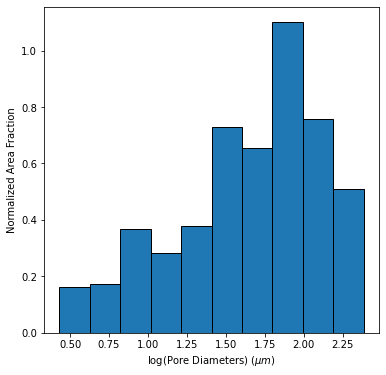

In [50]:
plt.figure(figsize=[6, 6])
plt.xlabel('log(Pore Diameters) ($\mu m$)')
plt.ylabel('Normalized Area Fraction')
fig = plt.bar(x=psd.logR, height=psd.pdf, width=psd.bin_widths, edgecolor='k')

In [33]:
bin_edges, cumulativeAreasNorm = area_weighted(np.log10(properties['equivalent_diameter']), properties['area'], 
                                                        binsize='auto', figsize=(6,4), dpi=100)

DESCRIPTIVE STATISTICS
Area-weighted mean pore or grain size = 1.36 microns
HISTOGRAM FEATURES
The modal interval is 1.53 - 1.64 microns
The number of classes are 20
The bin size is 0.11 according to the auto rule


In [34]:
#fig, ax = distribution(np.log(properties['equivalent_diameter']), plot='hist', binsize=20)

In [71]:
bin_edges_SEM, cumulativeVolumesNorm_SEM, h_SEM, mid_points, cdf_norm = Saltykov(np.log10(properties['equivalent_diameter']), 
                                                                                 properties['area'], numbins=50, return_data=True)

In [72]:
d50 = np.interp(50,cdf_norm,mid_points)
10**d50

50.52136833432425

Shapiro-Wilk test (lognormal):
0.98, 0.00 (test statistic, p-value)
It doesnt look like a lognormal distribution (p-value < 0.05)
(╯°□°）╯︵ ┻━┻


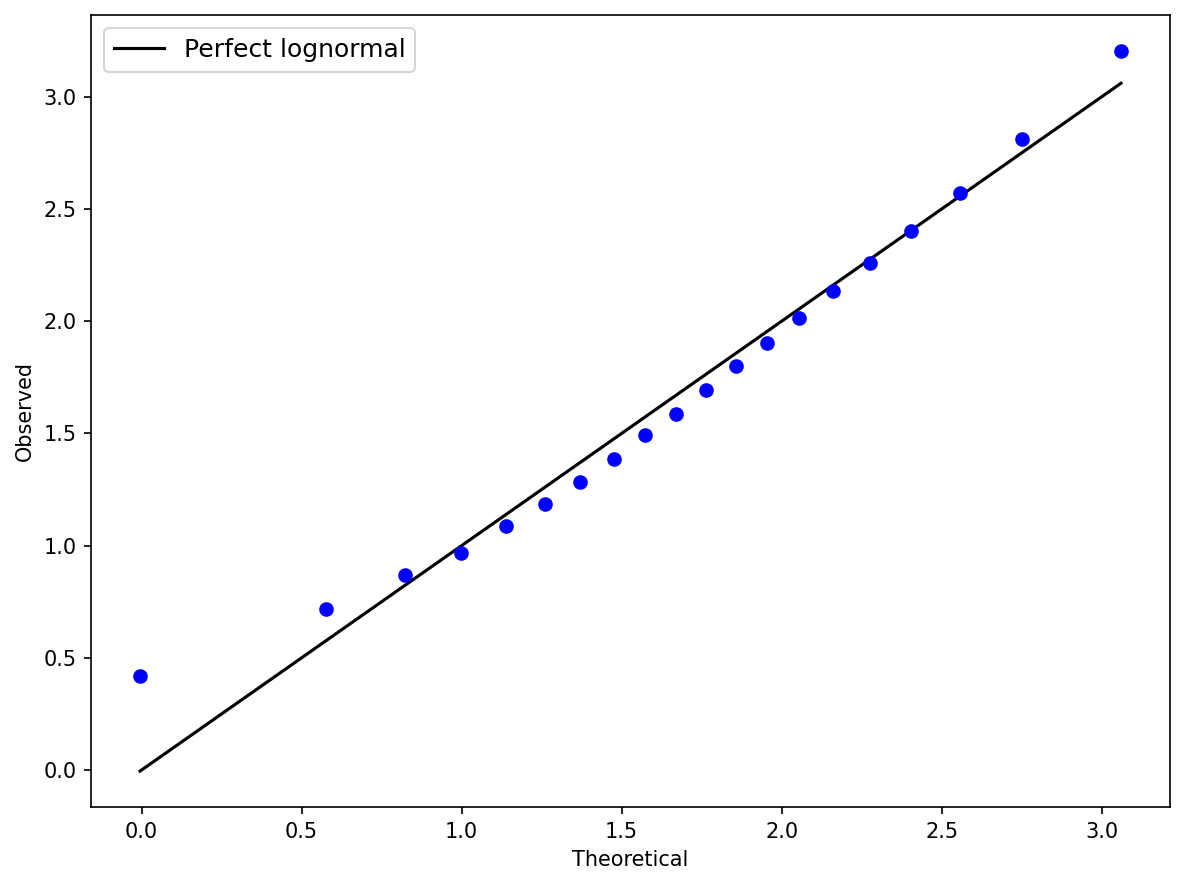

In [97]:
fig.savefig('Pore q-q plot.png',dpi=1000)

## From micro-CT

In [100]:
microCT = pd.read_csv (r'C:\Users\Hsafari\Desktop\SEM\BB\BB_Beam_Cropped_8bit_600z.filtered.Label-Analysis.csv')
microCT.head()

,EqDiameter,Volume3d,Area,Area3d,VoxelFaceArea,Sphericity,index
0,32.6749,18265.80,18265.80,4615.17,6269.40,0.220101,1
1,44.2252,45290.60,45290.60,8531.05,12013.90,0.218132,2
2,14.3739,1554.96,1554.96,1027.95,1341.36,0.191230,3
3,18.3735,3247.70,3247.70,1139.77,1705.86,0.281806,4
4,26.1923,9408.47,9408.47,3016.68,4111.56,0.216372,5


In [101]:
microCT.describe()

,EqDiameter,Volume3d,Area,Area3d,VoxelFaceArea,Sphericity,index
count,13584.000000,1.358400e+04,1.358400e+04,13584.000000,13584.000000,13584.000000,13584.000000
mean,35.779101,7.329283e+04,7.329283e+04,8822.063721,12986.910847,0.262009,6792.500000
std,26.562931,1.767860e+05,1.767860e+05,13874.575521,20431.674536,0.061455,3921.507363
min,3.349890,1.968300e+01,1.968300e+01,21.900500,43.740000,0.097388,1.000000
25%,13.399600,1.259710e+03,1.259710e+03,617.397750,933.120000,0.222991,3396.750000
50%,31.045700,1.566770e+04,1.566770e+04,3740.505000,5511.240000,0.248579,6792.500000
75%,52.159900,7.430330e+04,7.430330e+04,11423.650000,16781.600000,0.280882,10188.250000
max,251.965000,8.380000e+06,8.380000e+06,398674.000000,592502.000000,0.487517,13584.000000


In [102]:
bin_edges_CT, cumulativeVolumesNorm_CT, h_CT = volume_weighted(np.log10(microCT['EqDiameter']), microCT['Volume3d'], binsize=50);

DESCRIPTIVE STATISTICS
Volume-weighted mean pore or grain size = 1.89 microns
HISTOGRAM FEATURES
The modal interval is 1.97 - 2.02 microns
The number of classes are 50


TypeError: cannot unpack non-iterable NoneType object

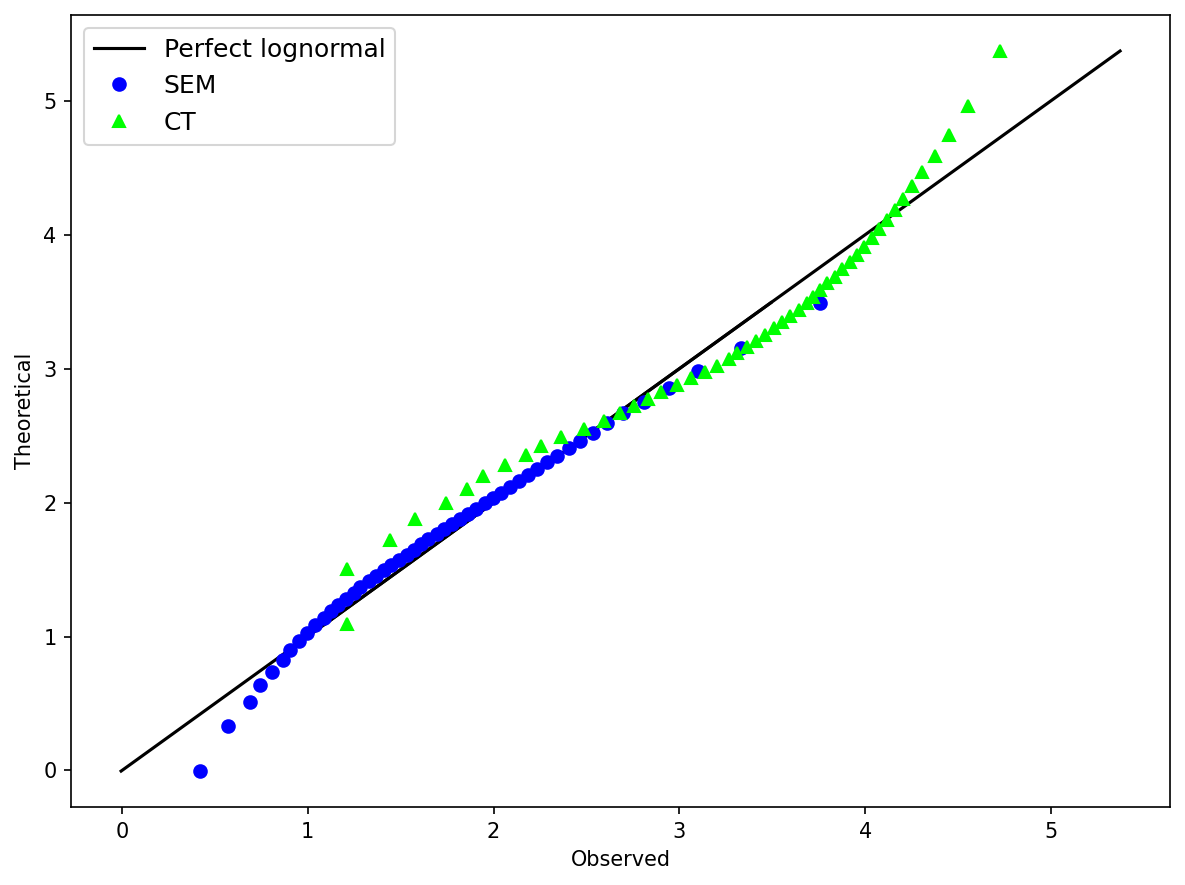

In [116]:
fig,ax = qq_plot(properties['equivalent_diameter'], microCT['EqDiameter'], 2, figsize=(8,6),dpi=150)

### Comparing SEM and micro-CT distributions

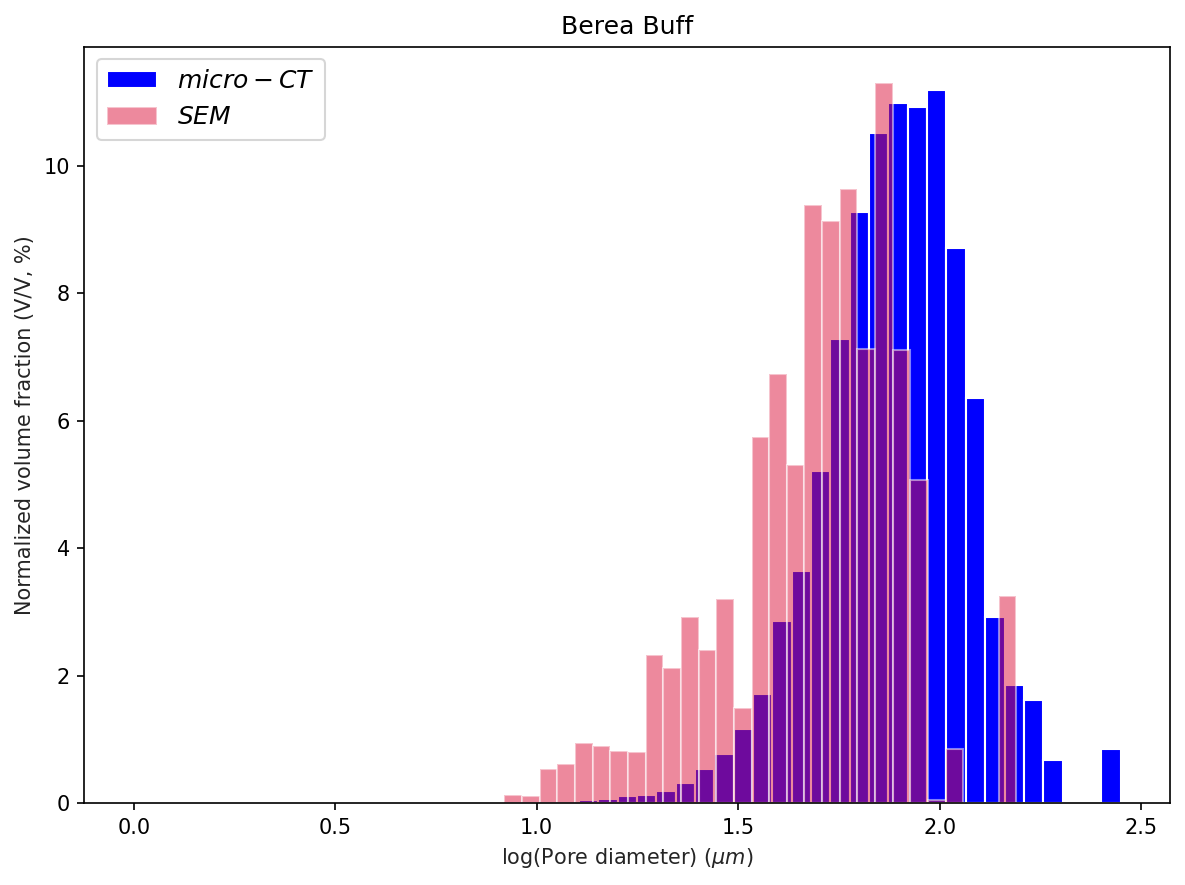

In [66]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

# figure aesthetics

ax.bar(bin_edges_CT, cumulativeVolumesNorm_CT, width=h_CT,
       color='blue',
       edgecolor='white',
       align='edge',
       label='$micro-CT$',
       alpha=None)

ax.bar(bin_edges_SEM, cumulativeVolumesNorm_SEM, width=h_SEM,
       color='crimson',
       edgecolor='white',
       align='edge',
       label='$SEM$',
       alpha=0.5)

ax.set_ylabel('Normalized volume fraction (V/V, %)', color='#252525')
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'log(Pore diameter) ($\mu m$)', color='#252525')
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Berea Buff')

fig.tight_layout()

In [67]:
fig.savefig('Pore.png',dpi=1000)

# Grain Size Distribution
## From SEM images

In [44]:
Two_Phase_Seg = []
for i in tqdm(range(len(Segmented_img))):
    Two_Phase = np.copy(Segmented_img[i])
    Two_Phase_Seg.append(Two_Phase)
    

100%|██████████| 12/12 [00:43<00:00,  3.59s/it]


In [45]:
Binary_img = []
for i in tqdm(range(len(Two_Phase_Seg))):
    img = np.copy(Two_Phase_Seg[i])
    img[(img==2) | (img==3) | (img==1)] = 1
    Binary_img.append(img)
#Two_Phase

100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


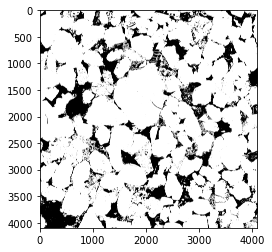

In [62]:
plt.imshow(Binary_img[11],cmap='gray')

In [19]:
# 0 is pore
# 1 is clay
# 2 is quartz
# 3 is feldspar
#Pores, _ = porosity_calc(Segmented_img,0)
Clay, _ = porosity_calc(Segmented_img,1)
Quartz, _ = porosity_calc(Segmented_img,2)
Feldspar, _ = porosity_calc(Segmented_img,3)

100%|██████████| 12/12 [00:00<00:00, 16.61it/s]


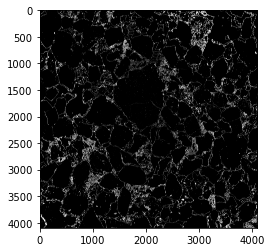

In [20]:
plt.imshow(Clay[11],cmap='gray')

In [21]:
dt_C, skel_C = distance_transform(Clay)

100%|██████████| 12/12 [01:04<00:00,  5.40s/it]


In [22]:
dt_Q, skel_Q = distance_transform(Quartz)

100%|██████████| 12/12 [03:44<00:00, 18.67s/it]


In [23]:
dt_F, skel_F = distance_transform(Feldspar)

100%|██████████| 12/12 [02:06<00:00, 10.50s/it]


In [75]:
#Grains, _ = porosity_calc(Two_Phase,1)

In [46]:
dt_G, skel_G = distance_transform(Binary_img)

100%|██████████| 12/12 [05:02<00:00, 25.20s/it]


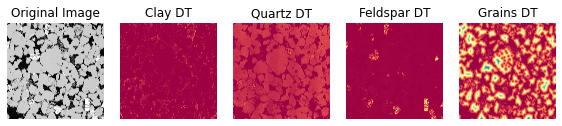

In [47]:
fig, axes = plt.subplots(1, 5, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img_rescale_final[11], cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(dt_C[11], cmap='Spectral')
ax[1].set_title('Clay DT')
ax[1].axis('off')

ax[2].imshow(dt_Q[11], cmap='Spectral')
ax[2].set_title('Quartz DT')
ax[2].axis('off')

ax[3].imshow(dt_F[11], cmap='Spectral')
ax[3].set_title('Feldspar DT')
ax[3].axis('off')

ax[4].imshow(dt_G[11], cmap='Spectral')
ax[4].set_title('Grains DT')
ax[4].axis('off')


fig.tight_layout()
plt.show()

In [24]:
regions_C,peaks_C = perform_watershed(dt_C, sigma=0.4, iters=1000)

100%|██████████| 12/12 [06:46<00:00, 33.84s/it]


In [25]:
regions_Q,peaks_Q = perform_watershed(dt_Q, sigma=0.6, iters=1000)

100%|██████████| 12/12 [08:23<00:00, 41.96s/it]


In [26]:
regions_F,peaks_F = perform_watershed(dt_F, sigma=0.4, iters=1000)

100%|██████████| 12/12 [10:25<00:00, 52.17s/it]


In [48]:
regions_G,peaks_G = perform_watershed(dt_G, sigma=0.4, iters=1000)

100%|██████████| 12/12 [04:25<00:00, 22.14s/it]


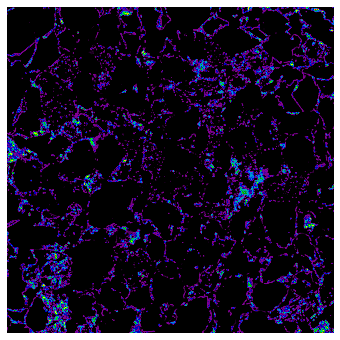

In [27]:
# Visualize the regions
plt.figure(figsize=(6, 6))
plt.imshow((regions_C[2]*Clay[2]), cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.show()

In [28]:
properties_C = property_extract(Clay,regions_C,scales_img)

100%|██████████| 12/12 [00:38<00:00,  3.18s/it]


In [29]:
properties_Q = property_extract(Quartz,regions_Q,scales_img)

100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


In [30]:
properties_F = property_extract(Feldspar,regions_F,scales_img)

100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


In [49]:
properties_G = property_extract(Binary_img,regions_G,scales_img)

100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


In [31]:
properties_C.head()

,Image,label,area,equivalent_diameter
0,1,1,29.667982,6.146092
1,1,2,14.504347,4.297384
2,1,3,7.087351,3.003980
3,1,4,2.307510,1.714063
4,1,5,5.109486,2.550608


In [32]:
properties_C[['equivalent_diameter','area']].describe()

,equivalent_diameter,area
count,79554.000000,79554.000000
mean,4.264212,19.609053
std,2.604535,30.084992
min,0.458103,0.164822
25%,2.509132,4.944664
50%,3.607104,10.218972
75%,5.243225,21.591698
max,40.585414,1293.688855


In [33]:
bin_edges_SEM_C, cumulativeVolumesNorm_SEM_C, h_SEM_C, mid_C, cdf_C = Saltykov(np.log10(properties_C['equivalent_diameter']), 
                                                                               properties_C['area'], numbins=50, 
                                                                               return_data=True)
bin_edges_SEM_Q, cumulativeVolumesNorm_SEM_Q, h_SEM_Q, mid_Q, cdf_Q = Saltykov(np.log10(properties_Q['equivalent_diameter']), 
                                                                               properties_Q['area'], numbins=50, 
                                                                               return_data=True)
bin_edges_SEM_F, cumulativeVolumesNorm_SEM_F, h_SEM_F, mid_F, cdf_F = Saltykov(np.log10(properties_F['equivalent_diameter']), 
                                                                               properties_F['area'], numbins=50, 
                                                                               return_data=True)


In [50]:
bin_edges_SEM_G, cumulativeVolumesNorm_SEM_G, h_SEM_G, mid_G, cdf_G = Saltykov(np.log10(properties_G['equivalent_diameter']), 
                                                                               properties_G['area'], numbins=50, 
                                                                               return_data=True)

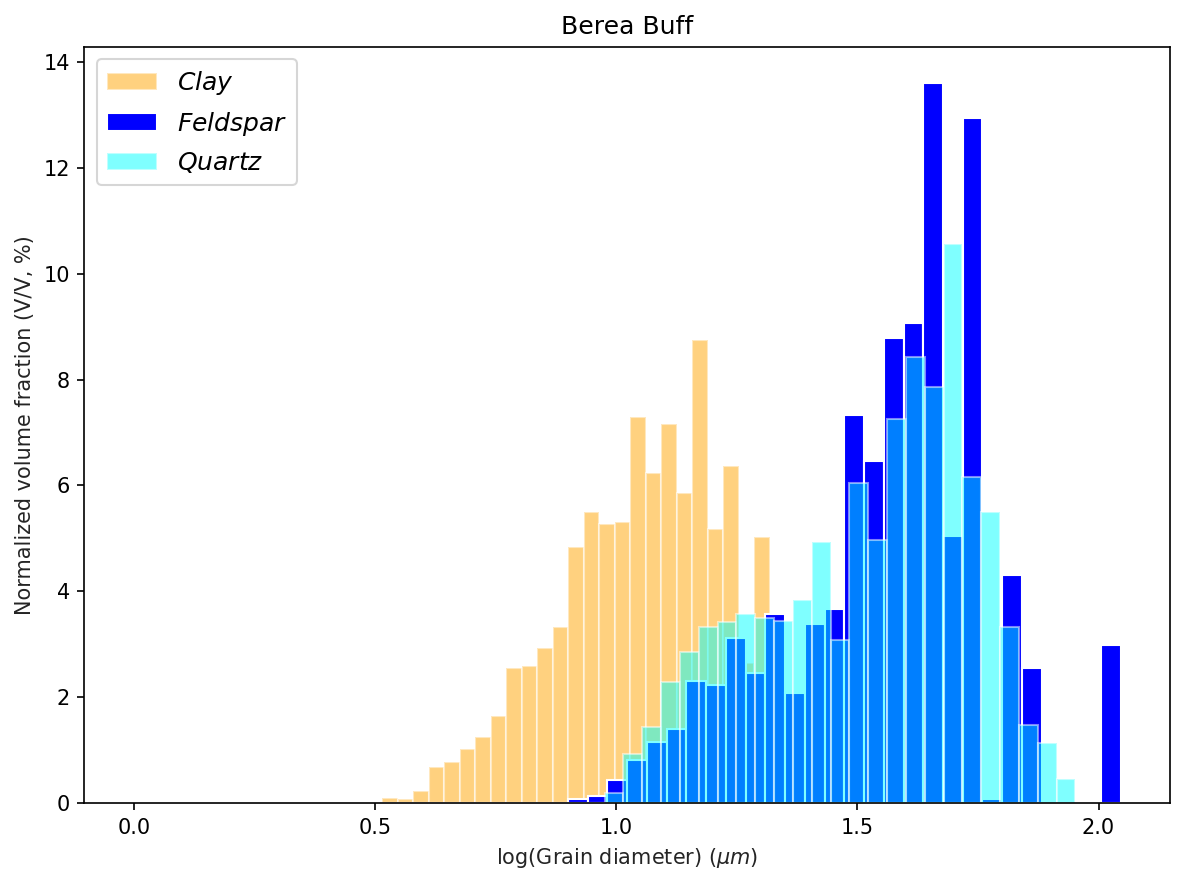

In [56]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

# figure aesthetics

ax.bar(bin_edges_SEM_C, cumulativeVolumesNorm_SEM_C, width=h_SEM_C,
       color='orange',
       edgecolor='white',
       align='edge',
       label='$Clay$',
       alpha=0.5)
ax.bar(bin_edges_SEM_F, cumulativeVolumesNorm_SEM_F, width=h_SEM_F,
       color='blue',
       edgecolor='white',
       align='edge',
       label='$Feldspar$',
       alpha=None)
ax.bar(bin_edges_SEM_Q, cumulativeVolumesNorm_SEM_Q, width=h_SEM_Q,
       color='cyan',
       edgecolor='white',
       align='edge',
       label='$Quartz$',
       alpha=0.5)

ax.set_ylabel('Normalized volume fraction (V/V, %)', color='#252525')
ax.set_xscale('linear')
ax.set_xlabel(r'log(Grain diameter) ($\mu m$)', color='#252525')
ax.legend(loc='best', fontsize=12)
ax.set_title('Berea Buff')

fig.tight_layout()

In [57]:
fig.savefig('Mineral.png',dpi=1000)

## From micro-CT

In [52]:
Grain_CT = pd.read_csv (r'C:\Users\Hsafari\Desktop\SEM\BB\BB_Beam_Cropped_8bit_600z.filtered.Label-Analysis_Grain.csv')
Grain_CT.head()

,EqDiameter,Volume3d,Area,Area3d,VoxelFaceArea,Sphericity,index
0,45.1722,48262.7,48262.7,10659.3,13734.4,0.182136,1
1,71.4815,191240.0,191240.0,25211.2,32119.7,0.192830,2
2,75.0522,221355.0,221355.0,23926.0,30690.9,0.223995,3
3,72.7914,201948.0,201948.0,24739.6,31886.5,0.203774,4
4,110.0020,696955.0,696955.0,63268.6,81706.3,0.181969,5


In [53]:
bin_edges_CT_G, cumulativeVolumesNorm_CT_G, h_CT_G = volume_weighted(np.log10(Grain_CT['EqDiameter']), Grain_CT['Volume3d'], binsize=50);

DESCRIPTIVE STATISTICS
Volume-weighted mean pore or grain size = 2.08 microns
HISTOGRAM FEATURES
The modal interval is 2.08 - 2.13 microns
The number of classes are 50


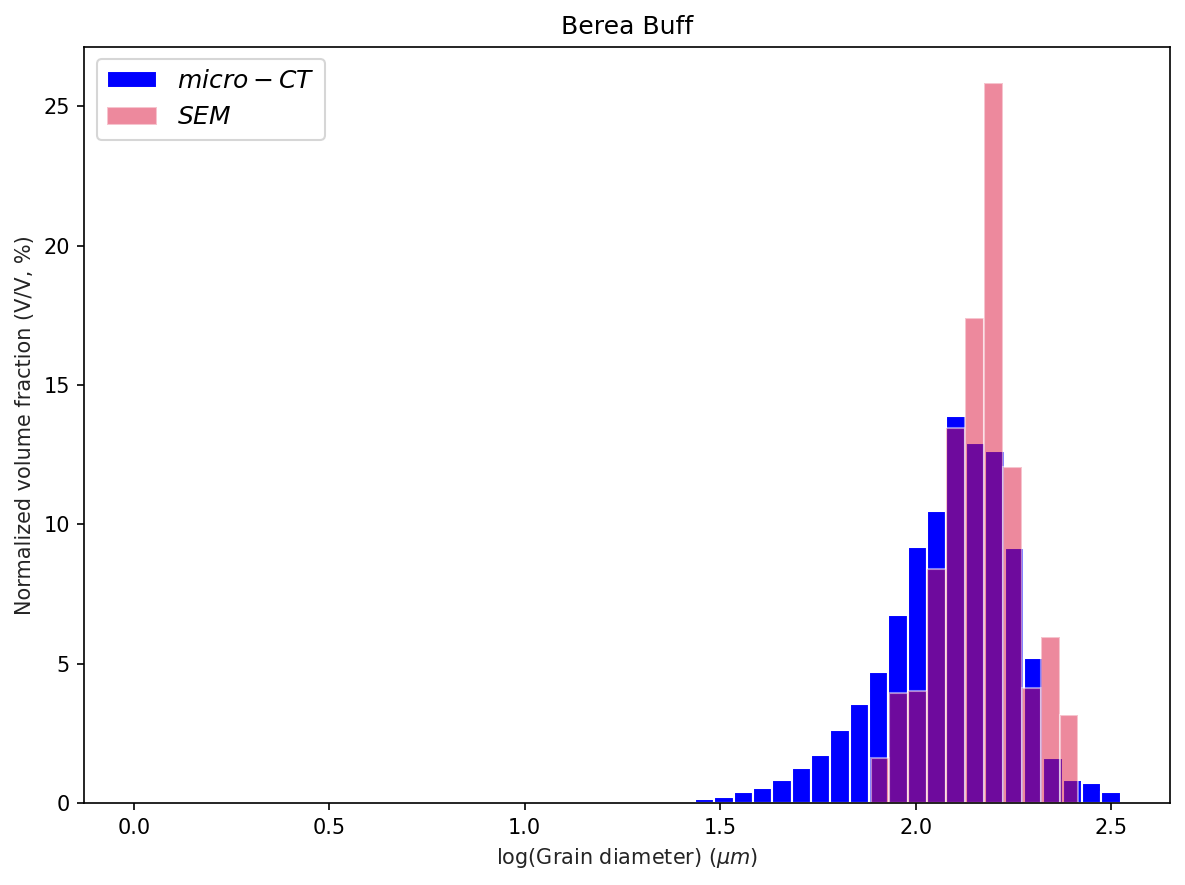

In [54]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

# figure aesthetics

ax.bar(bin_edges_CT_G, cumulativeVolumesNorm_CT_G, width=h_CT_G,
       color='blue',
       edgecolor='white',
       align='edge',
       label='$micro-CT$',
       alpha=None)

ax.bar(bin_edges_SEM_G, cumulativeVolumesNorm_SEM_G, width=h_SEM_G,
       color='crimson',
       edgecolor='white',
       align='edge',
       label='$SEM$',
       alpha=0.5)

ax.set_ylabel('Normalized volume fraction (V/V, %)', color='#252525')
ax.set_xscale('linear')
ax.set_xlabel(r'log(Grain diameter) ($\mu m$)', color='#252525')
ax.legend(loc='best', fontsize=12)
ax.set_title('Berea Buff')

fig.tight_layout()

In [55]:
fig.savefig('Grain.png',dpi=1000)